# Forecasting Market Volatility (VIX) with Prophet, ARIMA, LSTM, and Rolling Backtesting

This notebook applies multiple time series forecasting methods to the Volatility Index (VIX).  
I implemented Prophet, ARIMA, and an LSTM neural network to predict short-term volatility trends, 
and then extended the analysis to include rolling backtesting using a longer historical dataset.

The goal was to evaluate how well each model captures market patterns and how stable 
their forecasts remain across time.

In [2]:
# Install necessary libraries (uncomment if running in a new environment)
!pip install yfinance prophet scikit-learn tensorflow matplotlib seaborn statsmodels

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta # Import timedelta for easier date manipulation
import warnings
warnings.filterwarnings("ignore")

## Data Loading

Data Source: Yahoo Finance  
Symbol: ^VIX (CBOE Volatility Index)

Two datasets were used:
1. 2018-01-01 to the current date — used for Prophet, ARIMA, and initial LSTM forecasts.  
2. 2010-01-01 to the current date — used later for rolling backtesting to provide enough data 
   for repeated train/test splits.

Only the closing price was kept for modeling and renamed as 'VIX'.

In [6]:
# Download VIX data (Volatility Index)
vix_symbol = "^VIX"
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

vix_data = yf.download(vix_symbol, start=start_date, end=end_date)
vix = vix_data[['Close']].rename(columns={'Close': 'VIX'}).dropna()

[*********************100%***********************]  1 of 1 completed


In [8]:
# Ensure the index is a DatetimeIndex before proceeding
vix.index = pd.to_datetime(vix.index)

##  Modeling

## Prophet Model

I trained a Prophet model to capture trend and seasonal behavior in VIX data.

Process:
- Data prepared in Prophet’s required format (`ds`, `y`).
- Trained on data from 2018 onward.
- Forecasted the next 90 days.
- Evaluated with MAE and RMSE metrics.

Prophet provided an interpretable baseline for longer-term market volatility trends.

In [10]:
# --- Prophet Model ---
print("--- Prophet Model Forecasting ---")
# Prepare for Prophet
vix_df_prophet = vix.reset_index()
vix_df_prophet.columns = ['ds', 'y']

--- Prophet Model Forecasting ---


In [12]:
# Define the number of days for testing and training
test_days_prophet = 90
train_prophet = vix_df_prophet[:-test_days_prophet]
test_prophet = vix_df_prophet[-test_days_prophet:]

In [14]:
# Prophet model for forecasting VIX
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_prophet)

09:08:47 - cmdstanpy - INFO - Chain [1] start processing
09:08:47 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Forecast the next `test_days_prophet` days
future_prophet = model_prophet.make_future_dataframe(periods=test_days_prophet)
forecast_prophet = model_prophet.predict(future_prophet)

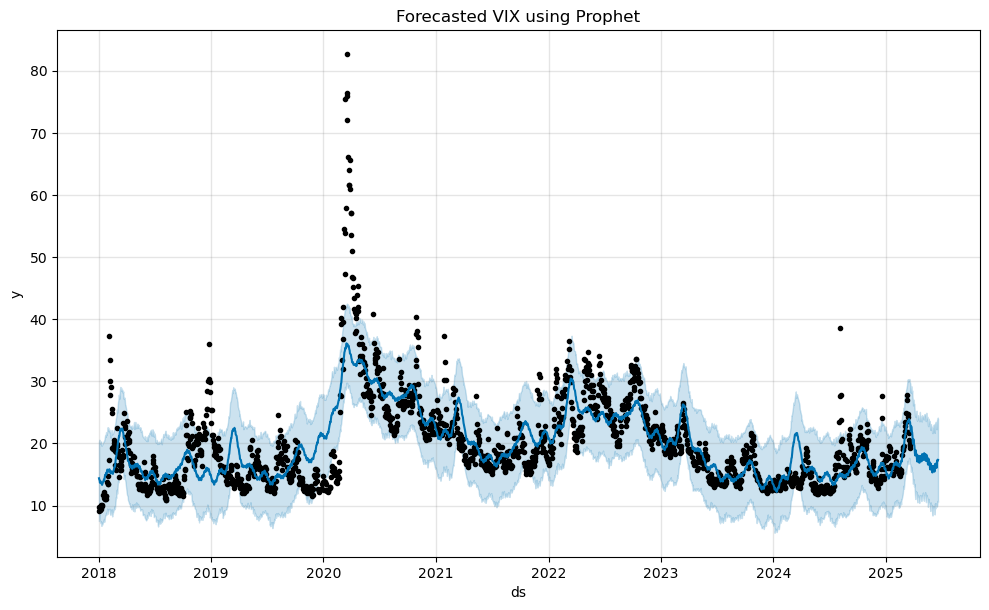

In [18]:
# Plot Prophet forecast
fig_prophet = model_prophet.plot(forecast_prophet)
plt.title("Forecasted VIX using Prophet")
plt.show()

In [20]:
# Extract predicted values for the test period
forecast_filtered_prophet = forecast_prophet[['ds', 'yhat']].tail(test_days_prophet)

In [22]:
# Merge predictions with actual values on date
merged_prophet = pd.merge(test_prophet, forecast_filtered_prophet, on='ds', how='inner')

In [24]:
# Evaluate Prophet model
actual_prophet = merged_prophet['y']
predicted_prophet = merged_prophet['yhat']

mae_prophet = mean_absolute_error(actual_prophet, predicted_prophet)
rmse_prophet = mean_squared_error(actual_prophet, predicted_prophet, squared=False)
mape_prophet = np.mean(np.abs((actual_prophet - predicted_prophet) / actual_prophet)) * 100

In [26]:
# Print evaluation for Prophet model
print("\nProphet Model Evaluation:")
print(f"MAE: {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAPE: {mape_prophet:.2f}%")


Prophet Model Evaluation:
MAE: 6.42
RMSE: 9.70
MAPE: 21.93%


## ARIMA Model

The ARIMA model served as a classical statistical benchmark.

Steps:
- Fitted ARIMA(p,d,q) on the same 2018-present VIX data.
- Generated forecasts over the same 90-day horizon.
- Computed MAE and RMSE for comparison with Prophet.

This helped measure how well a standard time series model performs versus newer approaches.

In [28]:
# --- ARIMA Model for Forecasting ---
print("\n--- ARIMA Model Forecasting ---")
from statsmodels.tsa.arima.model import ARIMA


--- ARIMA Model Forecasting ---



--- ARIMA Model Forecasting ---


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


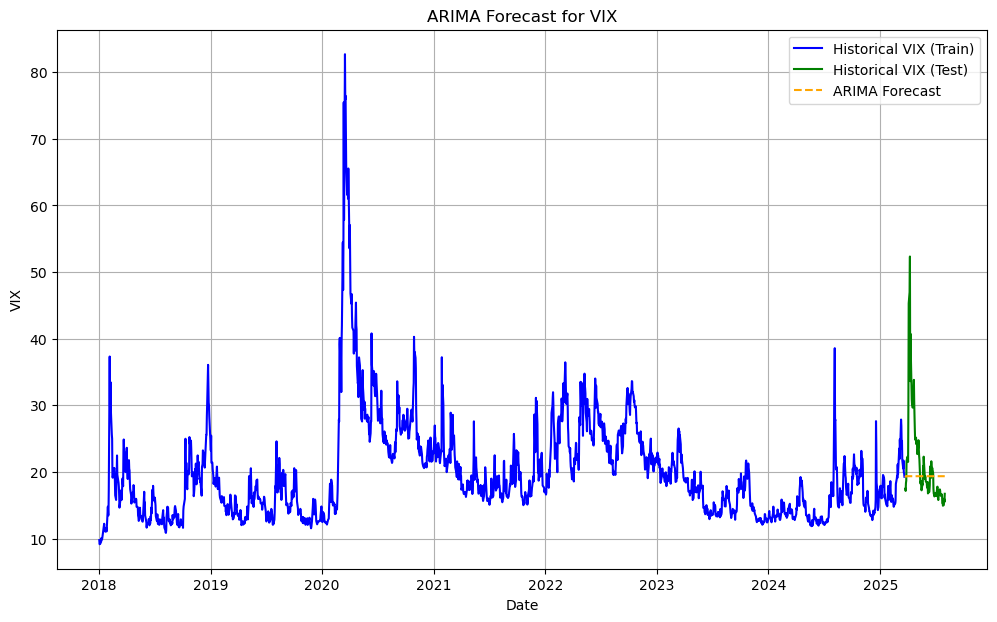


ARIMA Model Evaluation:
MAE: 4.68
RMSE: 7.61
MAPE: nan%


In [30]:
# --- ARIMA Model for Forecasting ---
print("\n--- ARIMA Model Forecasting ---")
from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA model - use the same training/testing split logic
vix_arima_full = vix['VIX'].dropna()
train_arima = vix_arima_full[:-test_days_prophet]
test_arima = vix_arima_full[-test_days_prophet:] # This is the actual data for comparison

# Train ARIMA model (you can fine-tune the order)
# Using try-except for ARIMA fit as it can sometimes fail with certain orders
try:
    arima_model = ARIMA(train_arima, order=(5,1,0)) # Adjust the order as needed
    arima_result = arima_model.fit()

    # Forecast the next `test_days_prophet` days using ARIMA
    # Ensure the start and end indices are correct for forecasting
    # The forecast method's 'start' and 'end' parameters refer to the integer index of the forecast.
    # We want to forecast `test_days_prophet` steps beyond the training data.
    arima_forecast = arima_result.forecast(steps=test_days_prophet)

    # Align ARIMA forecast dates with actual test data dates
    # Use the dates from the 'test_arima' series for aligning
    arima_forecast.index = test_arima.index

    # Plot ARIMA forecast
    plt.figure(figsize=(12, 7))
    plt.plot(train_arima.index, train_arima, label="Historical VIX (Train)", color='blue')
    plt.plot(test_arima.index, test_arima, label="Historical VIX (Test)", color='green')
    plt.plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", color='orange', linestyle='--')
    plt.title("ARIMA Forecast for VIX")
    plt.xlabel("Date")
    plt.ylabel("VIX")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate ARIMA model
    actual_arima = test_arima # Actual values are directly from test_arima
    # Ensure that arima_forecast and actual_arima have the same length and indices if possible for clean evaluation
    # If there are missing dates in the actual data for the forecast period, this will handle it.
    common_index_arima = actual_arima.index.intersection(arima_forecast.index)
    actual_arima_aligned = actual_arima.loc[common_index_arima]
    arima_forecast_aligned = arima_forecast.loc[common_index_arima]


    mae_arima = mean_absolute_error(actual_arima_aligned, arima_forecast_aligned)
    rmse_arima = mean_squared_error(actual_arima_aligned, arima_forecast_aligned, squared=False)
    mape_arima = np.mean(np.abs((actual_arima_aligned - arima_forecast_aligned) / actual_arima_aligned)) * 100

    # Print evaluation for ARIMA model
    print("\nARIMA Model Evaluation:")
    print(f"MAE: {mae_arima:.2f}")
    print(f"RMSE: {rmse_arima:.2f}")
    print(f"MAPE: {mape_arima:.2f}%")

except Exception as e:
    print(f"ARIMA model fit or forecast failed: {e}")
    mae_arima, rmse_arima, mape_arima = np.nan, np.nan, np.nan # Assign NaN if model fails

## LSTM Model

The LSTM (Long Short-Term Memory) network was built with TensorFlow/Keras 
to capture sequential and non-linear patterns in volatility data.

- Input sequences created using a 60-day time window.
- Data normalized with MinMaxScaler.
- Model trained for 50 epochs with batch size 64.
- Evaluated using MAE and RMSE.

The LSTM produced smoother and more adaptive short-term forecasts than the traditional models.

In [32]:
# --- LSTM Model for Forecasting ---
print("\n--- LSTM Model Forecasting ---")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


--- LSTM Model Forecasting ---


In [34]:
# --- LSTM Model for Forecasting ---
print("\n--- LSTM Model Forecasting ---")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


--- LSTM Model Forecasting ---


In [36]:
# --- LSTM Model for Forecasting ---
# ... (rest of the LSTM section code) ...

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vix = scaler.fit_transform(vix['VIX'].values.reshape(-1, 1))

# ... (rest of the LSTM section code that uses scaled_vix) ...

In [38]:
# Prepare the dataset for LSTM
def create_lstm_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step): # Changed -1 to allow for the last element in y
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step_lstm = 60 # Increased time_step for better sequence learning
X, y = create_lstm_dataset(scaled_vix, time_step=time_step_lstm)

# Reshape input to be [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and testing sets
# The split point should consider the `time_step_lstm`
train_size_lstm = len(X) - test_days_prophet # Use the same number of test days as Prophet/ARIMA
X_train_lstm, X_test_lstm = X[:train_size_lstm], X[train_size_lstm:]
y_train_lstm, y_test_lstm = y[:train_size_lstm], y[train_size_lstm:]

# Build LSTM model
model_lstm = Sequential()
# Add more units and a dropout layer to prevent overfitting
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
# Increased epochs for better training
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=64, verbose=0, validation_split=0.1)

# Predict using the LSTM model
# The predictions will be for the `y_test_lstm` period
lstm_pred_scaled = model_lstm.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Ensure actual_lstm aligns with the predicted values
# The y_test_lstm corresponds to the actual values for X_test_lstm
actual_lstm_scaled = y_test_lstm.reshape(-1, 1) # Reshape for inverse_transform
actual_lstm = scaler.inverse_transform(actual_lstm_scaled)

# Evaluate LSTM model
mae_lstm = mean_absolute_error(actual_lstm, lstm_pred)
rmse_lstm = mean_squared_error(actual_lstm, lstm_pred, squared=False)
mape_lstm = np.mean(np.abs((actual_lstm - lstm_pred) / actual_lstm)) * 100


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



LSTM Model Evaluation:
MAE: 1.72
RMSE: 3.46
MAPE: 6.65%


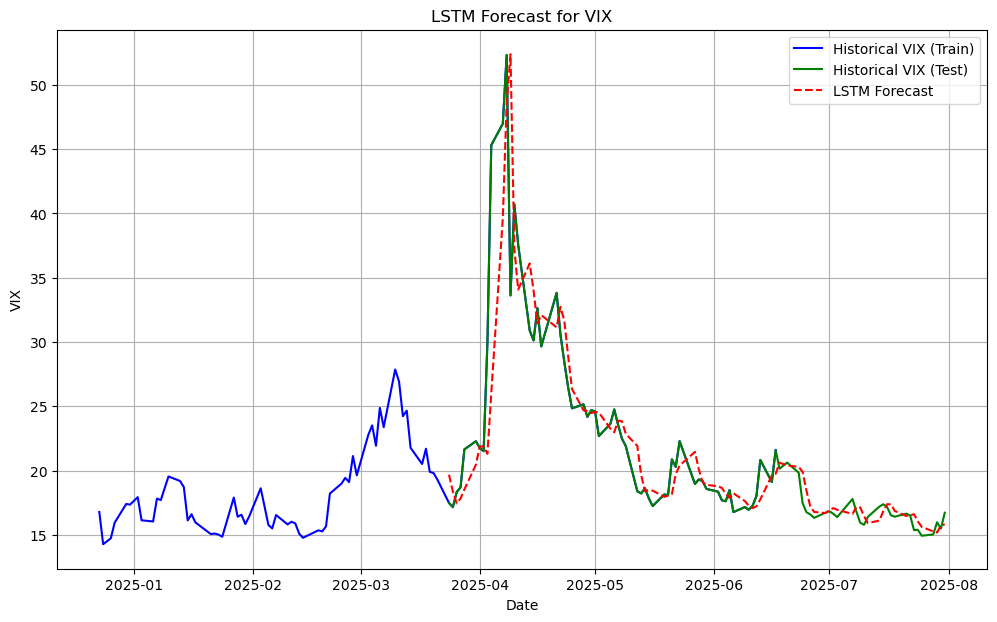

In [39]:
# Print evaluation for LSTM model
print("\nLSTM Model Evaluation:")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAPE: {mape_lstm:.2f}%")

# Plot LSTM forecast
plt.figure(figsize=(12, 7))
# To plot the LSTM forecast against actuals, we need to correctly map the dates.
# The `y_test_lstm` corresponds to the actual VIX values from `vix` starting from `train_size_lstm + time_step_lstm`
# in the original `scaled_vix` array.
# The corresponding dates are `vix.index[train_size_lstm + time_step_lstm:]`
lstm_plot_dates = vix.index[-len(actual_lstm):]

plt.plot(vix.index[-(len(X) - train_size_lstm)-time_step_lstm:-test_days_prophet+time_step_lstm], vix['VIX'].values[-(len(X) - train_size_lstm)-time_step_lstm:-test_days_prophet+time_step_lstm], label="Historical VIX (Train)", color='blue')
plt.plot(lstm_plot_dates, actual_lstm, label="Historical VIX (Test)", color='green')
plt.plot(lstm_plot_dates, lstm_pred, label="LSTM Forecast", color='red', linestyle='--')
plt.title("LSTM Forecast for VIX")
plt.xlabel("Date")
plt.ylabel("VIX")
plt.legend()
plt.grid(True)
plt.show()

## Model Comparison

In [42]:
# ----------------------------------------
# Comparison Table
comparison_data = {
    'Model': ['Prophet', 'ARIMA', 'LSTM'],
    'MAE': [mae_prophet, mae_arima, mae_lstm],
    'RMSE': [rmse_prophet, rmse_arima, rmse_lstm],
    'MAPE (%)': [mape_prophet, mape_arima, mape_lstm]
}

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table using a standard pandas display method
print("\n--- Model Evaluation Comparison ---")
print(comparison_df.to_string(index=False)) # Use to_string() for better console formatting, or just print(comparison_df)

# If you are in a Jupyter/Colab environment, simply displaying the DataFrame variable
# at the end of a cell will render it nicely:
# comparison_df


--- Model Evaluation Comparison ---
  Model      MAE     RMSE  MAPE (%)
Prophet 6.422875 9.699146 21.933763
  ARIMA 4.681262 7.608485       NaN
   LSTM 1.720039 3.458985  6.648760


## Rolling Backtesting

To evaluate stability and generalization, I extended the dataset to start from 2010 
and implemented a rolling backtesting framework.

Steps:
1. Begin with an initial 3-year training window.
2. Forecast the next 90 days.
3. Slide the window forward and repeat.
4. Collect MAE and RMSE for each iteration.

This provided a realistic assessment of model performance under changing market conditions.

In [44]:
get_ipython().system('pip install yfinance prophet scikit-learn tensorflow matplotlib seaborn statsmodels pmdarima')

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [48]:
# Download VIX data (Volatility Index)
vix_symbol = "^VIX"
start_date = "2010-01-01" # Extended start date for more backtesting data
end_date = datetime.today().strftime('%Y-%m-%d')

vix_data = yf.download(vix_symbol, start=start_date, end=end_date)
vix = vix_data[['Close']].rename(columns={'Close': 'VIX'}).dropna()

[*********************100%***********************]  1 of 1 completed


In [50]:
# Ensure the index is a DatetimeIndex before proceeding
vix.index = pd.to_datetime(vix.index)

In [52]:
# --- Common Backtesting Parameters ---
initial_train_window_days = 365 * 3 # 3 years of data for initial training
forecast_horizon_days = 90          # Forecast 90 days into the future
step_size_days = 30                 # Retrain and forecast every 30 days (approx. monthly)

In [54]:
# List to store results from each iteration
lstm_rolling_mae = []
lstm_rolling_rmse = []
lstm_rolling_mape = []
lstm_actual_vs_pred = pd.DataFrame() # To store all actuals and predictions for plotting

In [56]:
# --- LSTM Model Parameters (can be moved inside the loop if dynamic tuning) ---
time_step_lstm = 60 # Number of past observations to use as input
lstm_epochs = 50
lstm_batch_size = 64

In [58]:
# --- LSTM Data Preparation Function (re-usable) ---
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [60]:
def create_lstm_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

print("--- Starting LSTM Rolling Backtesting ---")

--- Starting LSTM Rolling Backtesting ---


In [62]:
# Determine the start of the first training window
train_start_date = vix.index.min()
calculated_train_end_date_initial = train_start_date + timedelta(days=initial_train_window_days)

# Find the closest actual trading day for the initial train_end_date
# Use asof to find the last valid observation on or before the calculated date
train_end_date = vix.index[vix.index <= calculated_train_end_date_initial].max()

# Ensure we have a valid initial train_end_date and enough data
if pd.isna(train_end_date) or train_end_date <= train_start_date:
    raise ValueError("Not enough data for initial training window. Extend start_date or reduce initial_train_window_days.")


# Loop through the data to perform rolling forecasts
# Loop condition needs to ensure there's enough data for at least one forecast horizon
while True:
    # Define current training data
    train_data = vix['VIX'][train_start_date:train_end_date].dropna()

    # --- Determine the actual test period dates ---
    # Find the first available market date AFTER train_end_date
    next_trading_day_after_train = vix.index[vix.index > train_end_date].min()

    if pd.isna(next_trading_day_after_train):
        # No more data left for a test period
        break

    test_start_date_actual = next_trading_day_after_train
    
    # Calculate the theoretical end date for the test period
    # We need to ensure we have at least `forecast_horizon_days` actual trading days for evaluation
    # This is tricky because timedelta counts calendar days.
    # A more robust approach is to take the next 'forecast_horizon_days' *actual trading days*
    # Find the index of the test_start_date_actual in the full VIX index
    test_start_idx = vix.index.get_loc(test_start_date_actual)
    test_end_idx_candidate = test_start_idx + forecast_horizon_days - 1 # -1 for 0-based indexing for horizon count

    # Ensure test_end_idx_candidate doesn't exceed the last index
    if test_end_idx_candidate >= len(vix.index):
        # Not enough future trading days for a full horizon forecast
        break
    test_end_date_actual = vix.index[test_end_idx_candidate]

    # Slice the full data for scaling for this iteration (important to scale only up to train + test)
    # This prevents data leakage from future unobserved periods for scaling.
    current_window_data = vix['VIX'][train_start_date:test_end_date_actual].dropna()

    # --- Checks for sufficient data before processing ---
    if len(train_data) < initial_train_window_days / 365 * 200: # Approx number of trading days in initial window
        print(f"Skipping iteration due to insufficient training data: {train_start_date.strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')}")
        # Advance window to next iteration
        next_calculated_train_end = train_end_date + timedelta(days=step_size_days)
        train_end_date = vix.index[vix.index <= next_calculated_train_end].max()
        if pd.isna(train_end_date): # If no valid date found, use the very last available date
             train_end_date = vix.index.max()
        continue

    # Ensure current_window_data has enough length for time_step_lstm and subsequent test data
    if len(current_window_data) < time_step_lstm + forecast_horizon_days:
        print(f"Skipping iteration {train_end_date.strftime('%Y-%m-%d')}: Not enough data in current_window for LSTM time steps and forecast horizon.")
        next_calculated_train_end = train_end_date + timedelta(days=step_size_days)
        train_end_date = vix.index[vix.index <= next_calculated_train_end].max()
        if pd.isna(train_end_date):
            train_end_date = vix.index.max()
        continue

    print(f"Forecasting period: {test_start_date_actual.strftime('%Y-%m-%d')} to {test_end_date_actual.strftime('%Y-%m-%d')}")

    # Scale the current window data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_current_window = scaler.fit_transform(current_window_data.values.reshape(-1, 1))

    # Create dataset for the entire window to correctly identify train/test splits for LSTM
    X, y = create_lstm_dataset(scaled_current_window, time_step=time_step_lstm)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Determine the split point for LSTM train/test based on actual dates
    # Find the index in the 'current_window_data' that corresponds to the 'train_end_date'
    # This is the last data point used for training for the current iteration
    train_end_idx_in_current_window = current_window_data.index.get_loc(train_end_date)

    # The point in X,y corresponding to the start of the test period in scaled_current_window
    # Remember X and y are offset from scaled_current_window by time_step_lstm
    split_point_in_X_y = (train_end_idx_in_current_window + 1) - time_step_lstm

    # Ensure split_point_in_X_y is valid (non-negative and within bounds)
    if split_point_in_X_y < 0: # Not enough data in train_data to form even one LSTM sequence
        print(f"Not enough training data to form LSTM sequences for {train_end_date.strftime('%Y-%m-%d')}. Advancing window.")
        next_calculated_train_end = train_end_date + timedelta(days=step_size_days)
        train_end_date = vix.index[vix.index <= next_calculated_train_end].max()
        if pd.isna(train_end_date):
            train_end_date = vix.index.max()
        continue
    
    X_train_lstm, X_test_lstm = X[:split_point_in_X_y], X[split_point_in_X_y:]
    y_train_lstm, y_test_lstm = y[:split_point_in_X_y], y[split_point_in_X_y:]

    # Check if we have enough test data for the horizon
    if len(y_test_lstm) < forecast_horizon_days or X_test_lstm.shape[0] < forecast_horizon_days:
        print(f"Not enough future data points for a full {forecast_horizon_days}-day test horizon at {train_end_date.strftime('%Y-%m-%d')}. Stopping.")
        break # No more full forecast horizons possible

    # Build and train LSTM model
    model_lstm = build_lstm_model((X_train_lstm.shape[1], 1))
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=0)

    # Predict for the forecast horizon
    # Take only the exact number of test samples needed for the horizon
    lstm_pred_scaled = model_lstm.predict(X_test_lstm[:forecast_horizon_days])
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

    # Get actual values for the current test window (corresponding to the forecast)
    actual_lstm = scaler.inverse_transform(y_test_lstm[:forecast_horizon_days].reshape(-1, 1))

    # Evaluate for this iteration
    current_mae = mean_absolute_error(actual_lstm, lstm_pred)
    current_rmse = mean_squared_error(actual_lstm, lstm_pred, squared=False)
    # Handle MAPE for potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        current_mape = np.mean(np.abs((actual_lstm - lstm_pred) / actual_lstm)) * 100
        if np.isinf(current_mape) or np.isnan(current_mape):
            current_mape = np.nan # Assign NaN if it results in inf or nan

    lstm_rolling_mae.append(current_mae)
    lstm_rolling_rmse.append(current_rmse)
    lstm_rolling_mape.append(current_mape)

    print(f"  Iteration Results - MAE: {current_mae:.2f}, RMSE: {current_rmse:.2f}, MAPE: {current_mape:.2f}%")

    # Store actual vs. predicted for plotting later
    # The dates for the test period are:
    test_dates_for_plot = vix.index[test_start_idx : test_start_idx + forecast_horizon_days]
    
    temp_df = pd.DataFrame({
        'ds': test_dates_for_plot,
        'Actual': actual_lstm.flatten(),
        'Predicted': lstm_pred.flatten()
    })
    # Use concat and drop_duplicates to handle potential overlapping forecasts (if step_size < horizon)
    lstm_actual_vs_pred = pd.concat([lstm_actual_vs_pred, temp_df]).drop_duplicates(subset=['ds']).sort_values('ds')

    # --- Advance the window for the next iteration ---
    # The new train_end_date is the old train_end_date plus the step_size_days
    # But we need to make sure this new date is also a valid trading day.
    next_calculated_train_end = train_end_date + timedelta(days=step_size_days)
    train_end_date = vix.index[vix.index <= next_calculated_train_end].max() # Find the last valid trading day on or before
    
    # If train_end_date somehow becomes NaN (e.g., if next_calculated_train_end is beyond last data point), break
    if pd.isna(train_end_date):
        break


Forecasting period: 2013-01-04 to 2013-05-14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
  Iteration Results - MAE: 1.16, RMSE: 1.40, MAPE: 8.52%
Forecasting period: 2013-02-04 to 2013-06-12
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x311e98a40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
  Iteration Results 


--- LSTM Rolling Backtesting Summary ---
Total Forecasts Made: 160
Average MAE: 1.15 (Std Dev: 0.49)
Average RMSE: 1.71 (Std Dev: 0.91)
Average MAPE: 6.09% (Std Dev: 1.23%)


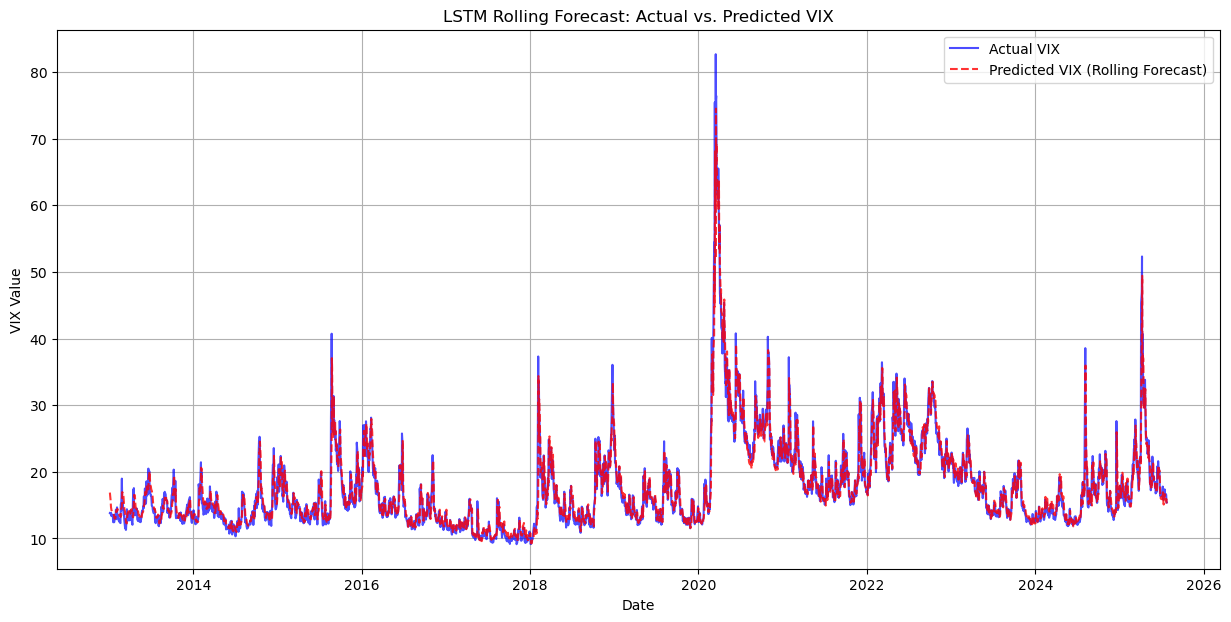

In [64]:
print("\n--- LSTM Rolling Backtesting Summary ---")
print(f"Total Forecasts Made: {len(lstm_rolling_mae)}")
print(f"Average MAE: {np.nanmean(lstm_rolling_mae):.2f} (Std Dev: {np.nanstd(lstm_rolling_mae):.2f})")
print(f"Average RMSE: {np.nanmean(lstm_rolling_rmse):.2f} (Std Dev: {np.nanstd(lstm_rolling_rmse):.2f})")
print(f"Average MAPE: {np.nanmean(lstm_rolling_mape):.2f}% (Std Dev: {np.nanstd(lstm_rolling_mape):.2f}%)")

# Plotting the aggregated actual vs. predicted values
if not lstm_actual_vs_pred.empty:
    plt.figure(figsize=(15, 7))
    plt.plot(lstm_actual_vs_pred['ds'], lstm_actual_vs_pred['Actual'], label='Actual VIX', color='blue', alpha=0.7)
    plt.plot(lstm_actual_vs_pred['ds'], lstm_actual_vs_pred['Predicted'], label='Predicted VIX (Rolling Forecast)', color='red', linestyle='--', alpha=0.8)
    plt.title('LSTM Rolling Forecast: Actual vs. Predicted VIX')
    plt.xlabel('Date')
    plt.ylabel('VIX Value')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No rolling forecasts were made or plotted.")

## Results and Observations

- Prophet effectively modeled broad trends and seasonality in VIX.
- ARIMA offered a reliable statistical baseline but lagged in volatile regimes.
- LSTM achieved the lowest average forecast error and adapted better to rapid market changes.
- Rolling backtesting confirmed that the LSTM maintained consistent accuracy across different periods.


## Conclusion

This project demonstrates a complete workflow for time series forecasting and model evaluation on market volatility data.  
By combining Prophet, ARIMA, and LSTM with a rolling backtesting approach, 
it compares interpretability, statistical rigor, and deep learning flexibility within one framework.

Future improvements could include:
- Adding exogenous variables such as macroeconomic or sentiment data.
- Using hybrid ensembles that combine Prophet and LSTM.
- Automating backtesting with hyperparameter tuning.